In [1]:
from pyspark.sql import SparkSession

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder.appName('Question2').getOrCreate()
df = spark.read.csv('insurance.csv', header=True, inferSchema=True)

In [3]:
df.show(5)

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
+---+------+------+--------+------+---------+-----------+
only showing top 5 rows



In [4]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



In [5]:
df.columns

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

In [6]:
len(df.columns)

7

In [7]:
df.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



+------+-----+
|smoker|count|
+------+-----+
|    no| 1064|
|   yes|  274|
+------+-----+



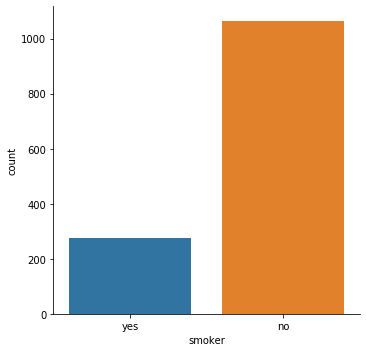

In [8]:
df.groupby('smoker').count().show()
dx = df.toPandas()
sns.catplot(x='smoker', kind='count', data=dx)

+--------+-----+
|children|count|
+--------+-----+
|       1|  324|
|       3|  157|
|       5|   18|
|       4|   25|
|       2|  240|
|       0|  574|
+--------+-----+



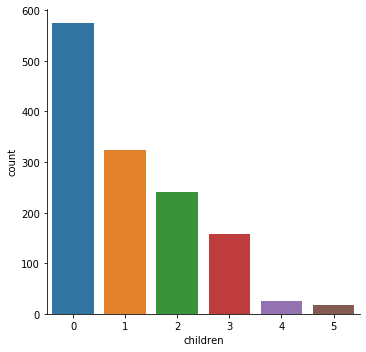

In [9]:
df.groupby('children').count().show()
sns.catplot(x='children', kind='count', data=dx)

BMI less than 25: 247
BMI greater than 25: 1091


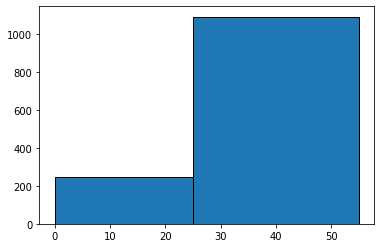

In [10]:
lt=0
mt=0
for i in dx['bmi']:
    if (i<=25):
        lt+=1
    else:
        mt+=1
print('BMI less than 25:', lt)
print('BMI greater than 25:', mt)
plt.hist(dx.bmi, bins=[0,25,55], edgecolor='black')
plt.show()

Text(0.5, 1.0, 'Age Vs Charges')

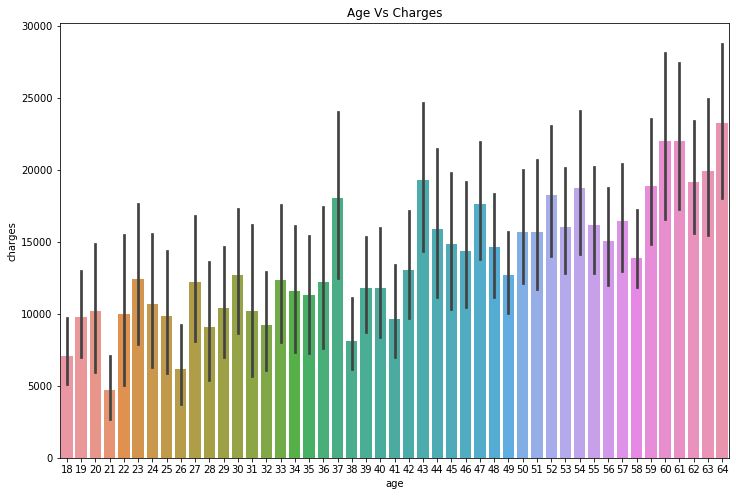

In [11]:
plt.figure(figsize=(12,8))
sns.barplot(x='age',y='charges', data=dx)
plt.title('Age Vs Charges')

Mean charges for 3 or less than 3 children: 11730.582377441857
Mean charges for more than 3 children: 13321.552083806173


Text(0.5, 1.0, 'No. of Children Vs Charges')

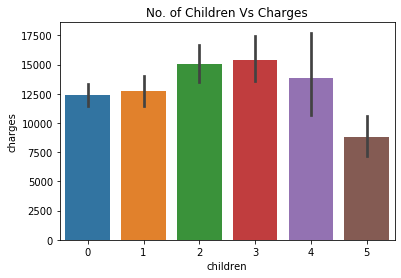

In [12]:
mean_chl,mean_chm = dx['charges'][dx['children'] > 3].mean(), dx['charges'][dx['children'] <= 3].mean()
print("Mean charges for 3 or less than 3 children:",mean_chl)
print("Mean charges for more than 3 children:",mean_chm)
sns.barplot(x='children',y='charges', data=dx)
plt.title('No. of Children Vs Charges')

In [13]:
cat_cols = [c[0] for c in df.dtypes if c[1]=='string']
cat_cols

['sex', 'smoker', 'region']

In [14]:
num_cols = [c[0] for c in df.dtypes if c[1]!='string']
num_cols = num_cols[0:3]
num_cols

['age', 'bmi', 'children']

In [16]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler
stages=[]
for cat_col in cat_cols:
    stringIndexer = StringIndexer(inputCol = cat_col, outputCol = cat_col + '_Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()],outputCols = [cat_col +'_OHE'])
    stages += [stringIndexer, encoder]
assemblerInputs = [c + '_OHE' for c in cat_cols] + num_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='asv_features')
stages += [assembler]
ss = StandardScaler(inputCol='asv_features', outputCol='features')
stages += [ss]

In [17]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df_pipetrans = pipelineModel.transform(df)
df_trans = df_pipetrans.select('features','charges')

In [18]:
df_trans = df_trans.withColumnRenamed('charges','label')

In [19]:
train_data, test_data = df_trans.randomSplit([0.7,0.3], seed = 1234)

In [20]:
from pyspark.ml.regression import LinearRegression
lm = LinearRegression(featuresCol='features',labelCol='label')
lm_model = lm.fit(train_data)

In [21]:
trainSummary=lm_model.summary
print("MAE: ", trainSummary.meanAbsoluteError)
print("MSE: ", trainSummary.meanSquaredError)
print("RMSE: ", trainSummary.rootMeanSquaredError)
print("R2: ", trainSummary.r2)

MAE:  4156.93024116977
MSE:  35294045.11896927
RMSE:  5940.879153708588
R2:  0.7514985778969564


In [22]:
lm_predictions = lm_model.transform(test_data)
lm_predictions.select('features','prediction','label').show(5)

+--------------------+-------------------+----------+
|            features|         prediction|     label|
+--------------------+-------------------+----------+
|(8,[0,1,5,6],[1.9...|-2231.7923860140763| 1694.7964|
|(8,[0,1,5,6],[1.9...| -305.2379873113532| 1702.4553|
|(8,[0,1,5,6],[1.9...|  491.9569362897746| 1705.6245|
|(8,[0,1,5,6],[1.9...|  7204.609924282191|3268.84665|
|(8,[0,1,5,6],[1.9...|  8451.691516250417|12404.8791|
+--------------------+-------------------+----------+
only showing top 5 rows



In [23]:
from pyspark.ml.evaluation import RegressionEvaluator
lm_evaluator = RegressionEvaluator(predictionCol = 'prediction',labelCol='label',metricName='r2')
print("R Squared on test data: ", lm_evaluator.evaluate(lm_predictions))

R Squared on test data:  0.7470182227409288


In [24]:
# Displaying metrics of the model over test data
res = lm_model.evaluate(test_data)
print("MAE: ", res.meanAbsoluteError)
print("MSE: ", res.meanSquaredError)
print("RMSE: ", res.rootMeanSquaredError)
print("R2: ", res.r2)

MAE:  4294.353080248329
MSE:  39767469.09471185
RMSE:  6306.1453436082365
R2:  0.7470182227409288
